### This note book has code to compare the distances / mutation rate derived from different sources

- Cen-hap flank distance vs. active array snp rate (mismatches / (matches + mismatches)) for closely aligned arrays (experiment with only showing points with an overall active array distance of less than X (say 0.2))

- Active array snp rate vs. short indel rate (short indel rate: # of indels less than 50bp / length of array).

- Active array snp rate vs. SV triangles rate (# of triangles / length of array) 

In [1]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
### cenhap matrices filepaths

cenhap_matrices = ["/chr11/no_recombinants/HPRC_chr11_50650000_51023358_54476419_54808189_no_recomb_het449_m_final_dgp.m",
"/chr10/no_recombinants/HPRC_chr10_39415000_39633793_41926237_42547087_42982864_42995500_no_recomb_m_final_dgp.m",
"/chr12_prelim/HPRC_chr12_34544731_34593492_37202490_37285321_het60_m_hprc_dgp_rnj.m",
"/chr17_prelim/HPRC_chr17_23278614_23433372_27571319_27700000_het114_m_hprc_dgp.m",
"/chr4/no_recomb/HPRC_chr4_49185000_49705154_55303192_55475000_no_recomb_het449_m_final_dgp.m",
"/chr6_prelim/standard/HPRC_chr6_58200000_58286706_61058390_61123742_het70_m_hprc_dgp_rnj.m"]

cenhap_matrices = ["/private/groups/patenlab/mira/centrolign/annotations/hprc_cenhap_trees_12042025"+item for item in cenhap_matrices]

In [3]:
## This function reads in the cenhap distance matrices to a pandas dataframe 

def load_matrix(file):
    # Read all lines except first
    with open(file) as f:
        lines = f.readlines()[1:]

    data = []
    sample_names = []
    for line in lines:
        parts = line.strip().split()
        sample = parts[0]
        values = list(map(float, parts[1:]))
        data.append(values)
        sample_names.append(sample)

    # Create dataframe
    df = pd.DataFrame(data, index=sample_names, columns=sample_names)

    return df


def to_long_format(df):
    df.index.name = "sample1"

    long = df.stack().rename("cenhap_dist").reset_index()

    # The second column (index 1) is always the sample2 column
    long = long.rename(columns={long.columns[1]: "sample2"})

    return long



# -------------------------
# Main loop
# -------------------------

all_long = []  # <-- FIXED: create the correct list

for f in cenhap_matrices:
    mat = load_matrix(f)
    long = to_long_format(mat)
    long["source_file"] = f
    all_long.append(long)  # <-- FIXED: append to correct list

cenhap_dists = pd.concat(all_long, ignore_index=True)

# Add chromosome extracted from the filepath
cenhap_dists["chr"] = cenhap_dists["source_file"].str.extract(r"(chr[0-9XYM]+)")

print(cenhap_dists.head())


   sample1    sample2  cenhap_dist  \
0  CHM13.0    CHM13.0     0.000000   
1  CHM13.0  HG00097.1     0.002401   
2  CHM13.0  HG00097.2     0.002408   
3  CHM13.0  HG00099.1     0.002405   
4  CHM13.0  HG00126.1     0.002405   

                                         source_file    chr  
0  /private/groups/patenlab/mira/centrolign/annot...  chr11  
1  /private/groups/patenlab/mira/centrolign/annot...  chr11  
2  /private/groups/patenlab/mira/centrolign/annot...  chr11  
3  /private/groups/patenlab/mira/centrolign/annot...  chr11  
4  /private/groups/patenlab/mira/centrolign/annot...  chr11  


In [4]:
## Read in SNP distances
path = "/private/groups/patenlab/mira/centrolign/analysis/SVs_pairwise/SNP_based_distances/"   # change to your directory

files = glob.glob(os.path.join(
    path,
    "*_r2_QC_v2_centrolign_pairwise_distance.csv"
))

dfs = []

for f in files:
    # extract chromosome name from filename
    base = os.path.basename(f)
    chr_name = base.split("_")[0]

    # read the tsv file (tab-separated)
    df = pd.read_csv(f, header=None, names=["sample1","sample2","snp_dist"])

    # add chr column
    df["chr"] = chr_name

    dfs.append(df)

# combine all files
snp_dist_df = pd.concat(dfs, ignore_index=True)
snp_dist_df.columns = ["sample1", "sample2", "snp_dist","chr"]
print(snp_dist_df)

           sample1    sample2  snp_dist   chr
0        HG03098.1  HG03784.1  0.007934  chr6
1        HG03098.1  NA20752.2  0.014866  chr6
2        HG01978.2  NA19835.1  0.006349  chr6
3        HG00741.1  NA18522.1  0.007092  chr6
4        HG00408.1  HG01496.1  0.001038  chr6
...            ...        ...       ...   ...
1132390  HG03471.2  NA18508.1  0.028102  chr5
1132391  HG02615.1  NA18948.1  0.020000  chr5
1132392  HG01891.1  NA19776.2  0.013699  chr5
1132393  HG00126.1  NA20827.1  0.000856  chr5
1132394  HG01150.2  HG01786.1  0.001502  chr5

[1132395 rows x 4 columns]


In [5]:
## Read in all pairs distance 

# Directory containing CSV files
pairwise_dist_dir = "/private/groups/patenlab/mira/centrolign/batch_submissions/centrolign/release2_QC_v2/all_pairs/distance_matrices/"  # this should be a folder path

# Collect all matching files
files = glob.glob(os.path.join(pairwise_dist_dir, "*_r2_QC_v2_centrolign_pairwise_distance.csv"))

all_dfs = []

for f in files:
    # Extract chr from filename
    # e.g. filename: "chr3_r2_QC_v2_centrolign_pairwise_distance.csv"
    basename = os.path.basename(f)
    chr_val = basename.split("_")[0]   # 'chr3'

    # Read CSV
    df = pd.read_csv(f, header=None,names=["sample1", "sample2", "direct_pairwise_dist","chr"])
    df["chr"] = chr_val
    all_dfs.append(df)

# Combine into one dataframe
all_pairs_dist_df = pd.concat(all_dfs, ignore_index=True)

all_pairs_dist_df.head()

,sample1,sample2,direct_pairwise_dist,chr
0,HG03098.1,HG03784.1,0.942968,chr6
1,HG03098.1,NA20752.2,0.974936,chr6
2,HG01978.2,NA19835.1,0.999883,chr6
3,HG00741.1,NA18522.1,0.999869,chr6
4,HG00408.1,HG01496.1,0.606856,chr6


In [6]:
# Merge the snp dist and cenhap dist data frames 

merged_df = pd.merge(
    cenhap_dists,
    snp_dist_df,
    on=["sample1", "sample2", "chr"],
    how="left"   # or "inner" if you only want matching rows
)

# now merge in the all pairs distances
merged_df = pd.merge(
    merged_df,
    all_pairs_dist_df,
    on=["sample1", "sample2", "chr"],
    how="left"   # or "inner" if you only want matching rows
)

merged_df.head()

,sample1,sample2,cenhap_dist,source_file,chr,snp_dist,direct_pairwise_dist
0,CHM13.0,CHM13.0,0.000000,/private/groups/patenlab/mira/centrolign/annot...,chr11,NaN,NaN
1,CHM13.0,HG00097.1,0.002401,/private/groups/patenlab/mira/centrolign/annot...,chr11,0.095238,0.999993
2,CHM13.0,HG00097.2,0.002408,/private/groups/patenlab/mira/centrolign/annot...,chr11,0.095238,0.999994
3,CHM13.0,HG00099.1,0.002405,/private/groups/patenlab/mira/centrolign/annot...,chr11,0.095238,0.999996
4,CHM13.0,HG00126.1,0.002405,/private/groups/patenlab/mira/centrolign/annot...,chr11,0.095238,0.999996


In [7]:
# ----------------------------
# 1. Define the bins and labels
# ----------------------------
bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
bin_labels = ["0–0.2", "0.2–0.4", "0.4–0.6", "0.6–0.8", "0.8–1.0"]

# Add a new column for the bin
merged_df["dist_bin"] = pd.cut(merged_df["direct_pairwise_dist"], bins=bins, labels=bin_labels, include_lowest=True)


### Plot cenhap distance versus SNP distance

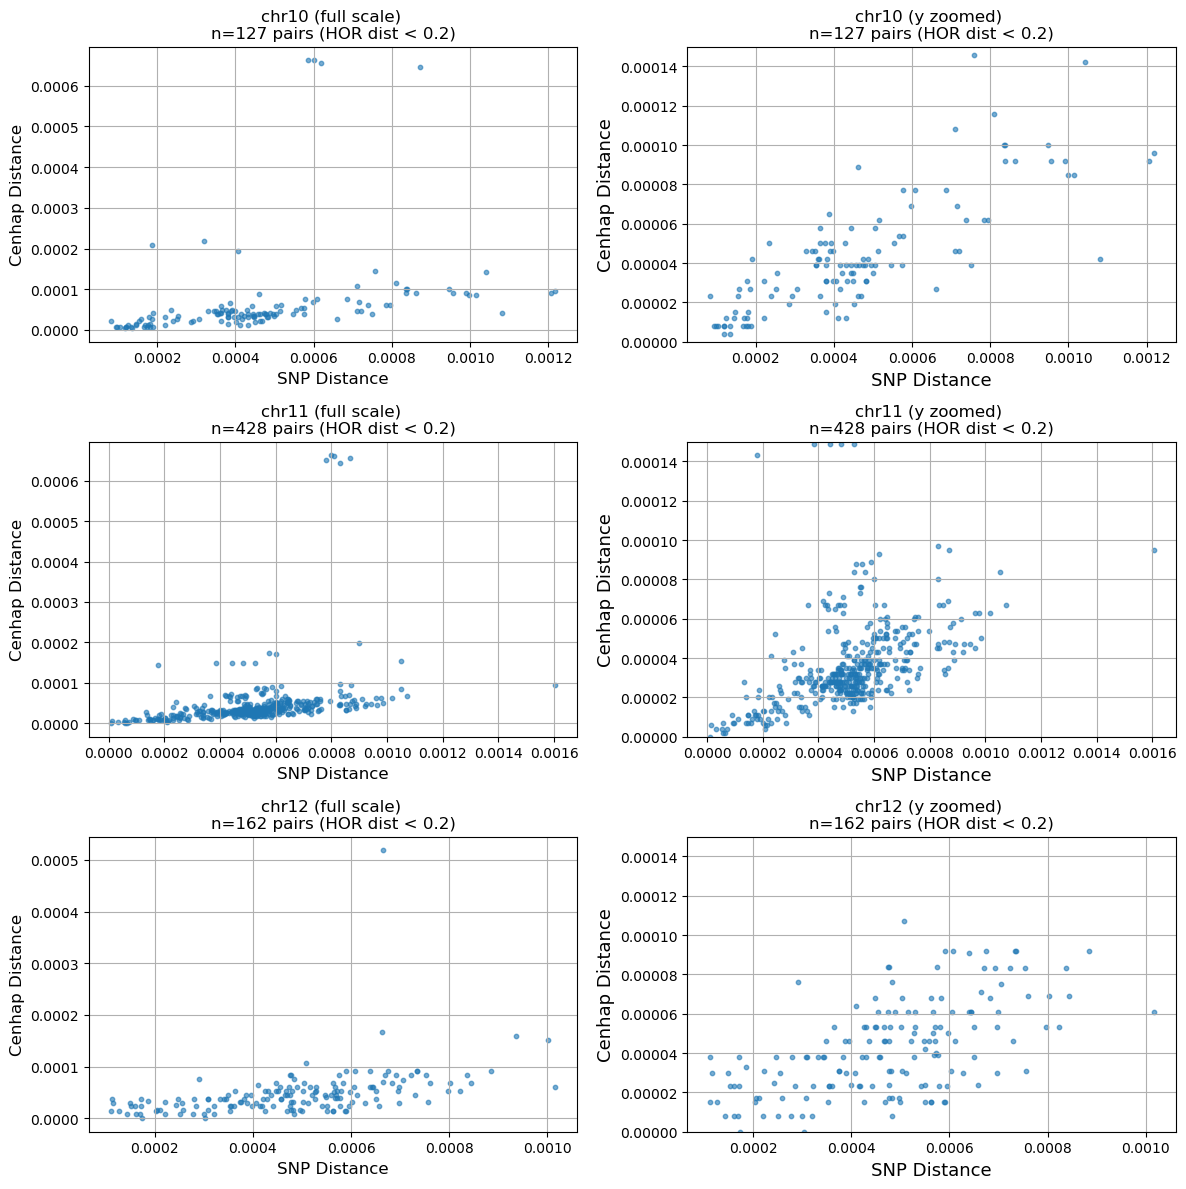

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Subset to specific chromosomes
selected_chrs = ["chr12", "chr11", "chr10"]
subset_df = merged_df[merged_df["chr"].isin(selected_chrs)]

# Filter only bin 0–0.2
bin_df = subset_df[subset_df["dist_bin"] == "0–0.2"]

# List of chromosomes
chromosomes = sorted(bin_df["chr"].unique())
n_chrs = len(chromosomes)

# Create figure: one row per chromosome, 2 columns per row
fig, axes = plt.subplots(nrows=n_chrs, ncols=2, figsize=(12, 4*n_chrs))

# Ensure axes is 2D (nrows x ncols) for consistent indexing
if n_chrs == 1:
    axes = axes.reshape(1, 2)
elif n_chrs > 1:
    axes = np.array(axes)

for i, chr_name in enumerate(chromosomes):
    chr_df = bin_df[bin_df["chr"] == chr_name]

    # Count unique samples
    n_pairs = len(chr_df)

    # Full scale plot
    ax_full = axes[i, 0]
    ax_full.scatter(chr_df["snp_dist"], chr_df["cenhap_dist"], alpha=0.6, s=10)
    ax_full.set_xlabel("SNP Distance",fontsize=12)
    ax_full.set_ylabel("Cenhap Distance",fontsize=12)
    ax_full.set_title(f"{chr_name} (full scale) \nn={n_pairs} pairs (HOR dist < 0.2)")
    ax_full.grid(True)

    # Zoomed y-axis plot
    ax_zoom = axes[i, 1]
    ax_zoom.scatter(chr_df["snp_dist"], chr_df["cenhap_dist"], alpha=0.6, s=10)
    ax_zoom.set_xlabel("SNP Distance",fontsize=13)
    ax_zoom.set_ylabel("Cenhap Distance",fontsize=13)
    ax_zoom.set_title(f"{chr_name} (y zoomed) \nn={n_pairs} pairs (HOR dist < 0.2)")
    ax_zoom.set_ylim(0, 0.00015)
    ax_zoom.grid(True)

plt.tight_layout()
plt.show()


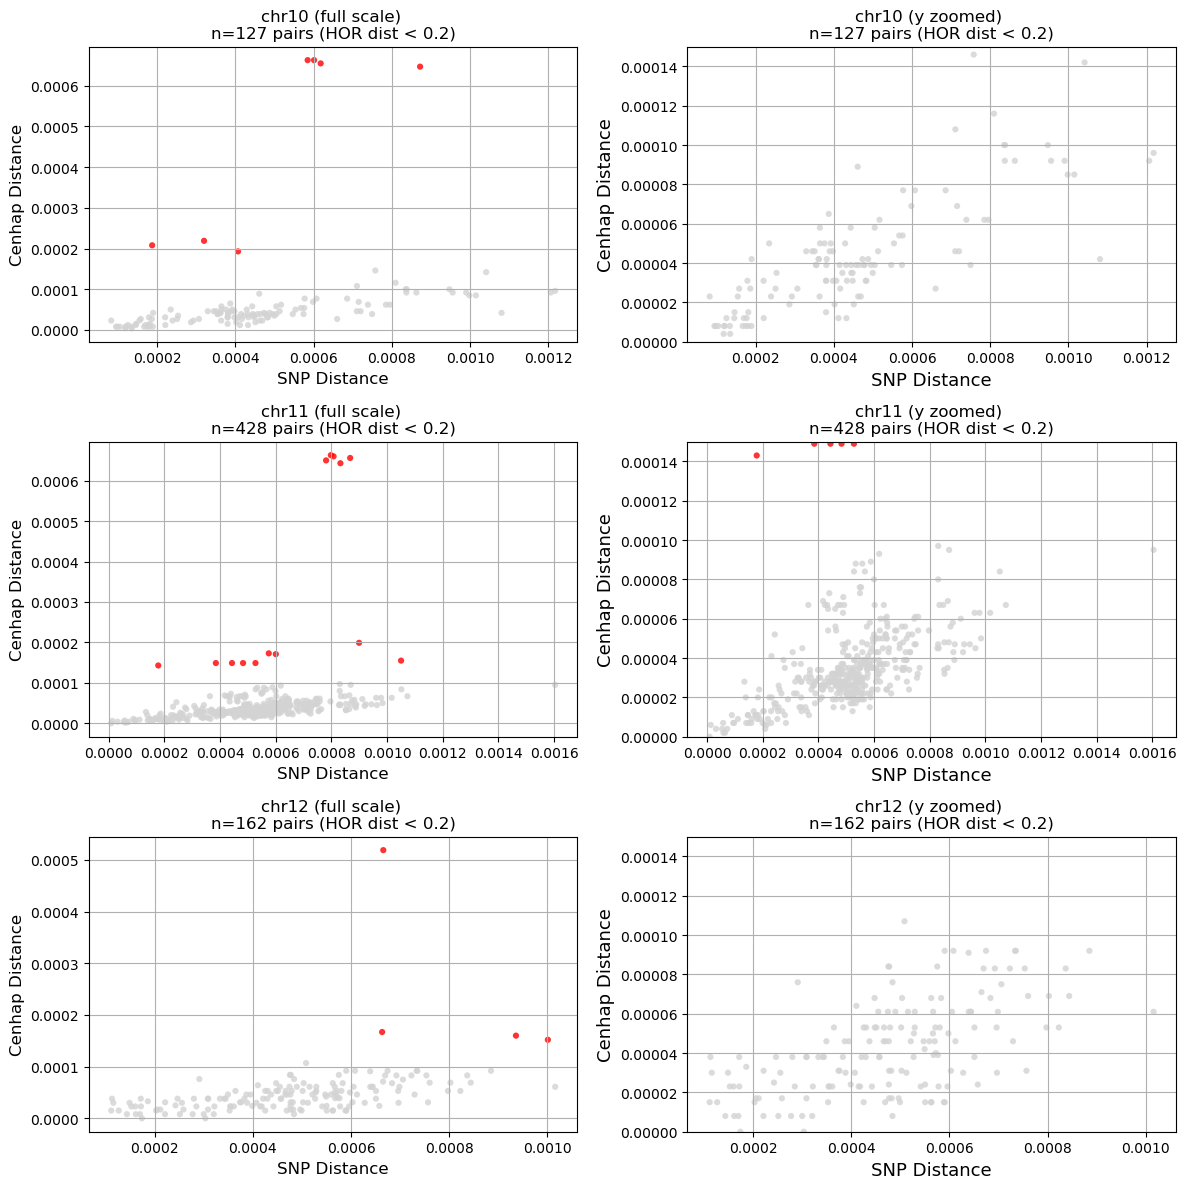

      sample1    sample2  cenhap_dist  \
0   HG00280.2  HG00741.1     0.000663   
1   HG00323.2  HG00741.1     0.000663   
2   HG00350.1  HG00741.1     0.000655   
3   HG00741.1  NA20850.2     0.000647   
4   HG00658.1  NA18944.1     0.000219   
5   HG00597.1  NA18944.1     0.000208   
6   HG02258.2  HG03270.2     0.000193   
7   HG03369.1  NA19468.1     0.000663   
8   NA19468.1  NA20282.2     0.000660   
9   HG02886.2  NA19468.1     0.000656   
10  HG02615.2  NA19468.1     0.000650   
11  NA19468.1  NA19700.1     0.000643   
12  HG02984.2  HG03540.2     0.000199   
13  HG03050.1  HG03540.2     0.000173   
14  HG02257.1  HG03540.2     0.000171   
15  HG02486.1  NA18508.2     0.000155   
16  HG00128.2  HG01081.1     0.000149   
17  HG00741.2  HG01081.1     0.000149   
18  HG02809.2  NA19240.2     0.000149   
19  HG02841.1  NA19240.2     0.000149   
20  HG01081.1  HG01786.1     0.000143   
21  NA18608.2  NA18976.1     0.000519   
22  HG00290.2  HG03710.1     0.000167   
23  HG00290.2  H

In [ ]:
### Coloring and exporting outliers for Sasha to examine 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Add diff column
merged_df["diff"] = merged_df["snp_dist"] - merged_df["cenhap_dist"]

# Subset to specific chromosomes
selected_chrs = ["chr12", "chr11", "chr10"]
subset_df = merged_df[merged_df["chr"].isin(selected_chrs)]

# Filter only bin 0–0.2
bin_df = subset_df[subset_df["dist_bin"] == "0–0.2"]

# List of chromosomes
chromosomes = sorted(bin_df["chr"].unique())
n_chrs = len(chromosomes)

# Mapping of chromosome → number of top points to highlight
topN_map = {
    "chr10": 7,
    "chr11": 14,
    "chr12": 4
}

# DataFrame to collect all top-N rows
top_rows_list = []

# Create figure: one row per chromosome, 2 columns per row
fig, axes = plt.subplots(nrows=n_chrs, ncols=2, figsize=(12, 4*n_chrs))

# Ensure axes is 2D (nrows x ncols) for consistent indexing
if n_chrs == 1:
    axes = axes.reshape(1, 2)
elif n_chrs > 1:
    axes = np.array(axes)

for i, chr_name in enumerate(chromosomes):
    chr_df = bin_df[bin_df["chr"] == chr_name]

    # ---- Identify top-N highest cenhap_dist for this chromosome ----
    N = topN_map.get(chr_name, 5)
    top_idx = chr_df["cenhap_dist"].nlargest(N).index

    # Collect top-N rows
    top_rows_list.append(chr_df.loc[top_idx])

    # Define colors: default light grey, top-N red
    colors = np.where(chr_df.index.isin(top_idx), "red", "lightgrey")

    # Count number of pairs
    n_pairs = len(chr_df)

    # -------------------- Full scale plot ---------------------
    ax_full = axes[i, 0]
    ax_full.scatter(chr_df["snp_dist"], chr_df["cenhap_dist"],
                    c=colors, alpha=0.8, s=20, edgecolor="none")
    ax_full.set_xlabel("SNP Distance", fontsize=12)
    ax_full.set_ylabel("Cenhap Distance", fontsize=12)
    ax_full.set_title(f"{chr_name} (full scale) \nn={n_pairs} pairs (HOR dist < 0.2)")
    ax_full.grid(True)

    # -------------------- Zoomed y-axis plot ------------------
    ax_zoom = axes[i, 1]
    ax_zoom.scatter(chr_df["snp_dist"], chr_df["cenhap_dist"],
                    c=colors, alpha=0.8, s=20, edgecolor="none")
    ax_zoom.set_xlabel("SNP Distance", fontsize=13)
    ax_zoom.set_ylabel("Cenhap Distance", fontsize=13)
    ax_zoom.set_title(f"{chr_name} (y zoomed) \nn={n_pairs} pairs (HOR dist < 0.2)")
    ax_zoom.set_ylim(0, 0.00015)
    ax_zoom.grid(True)

plt.tight_layout()
plt.show()

# Combine all top-N rows into a single DataFrame
top_df = pd.concat(top_rows_list).reset_index(drop=True)

# Optional: preview
print(top_df)

# Combine all top-N rows into a single DataFrame
top_df = pd.concat(top_rows_list).reset_index(drop=True)

# Write to CSV
top_df.to_csv("/private/groups/patenlab/mira/cenhap_snp_dist_outliers.csv", index=False)

# Optional: preview
print(f"{len(top_df)} rows written to top_cenhap_dist_rows.csv")



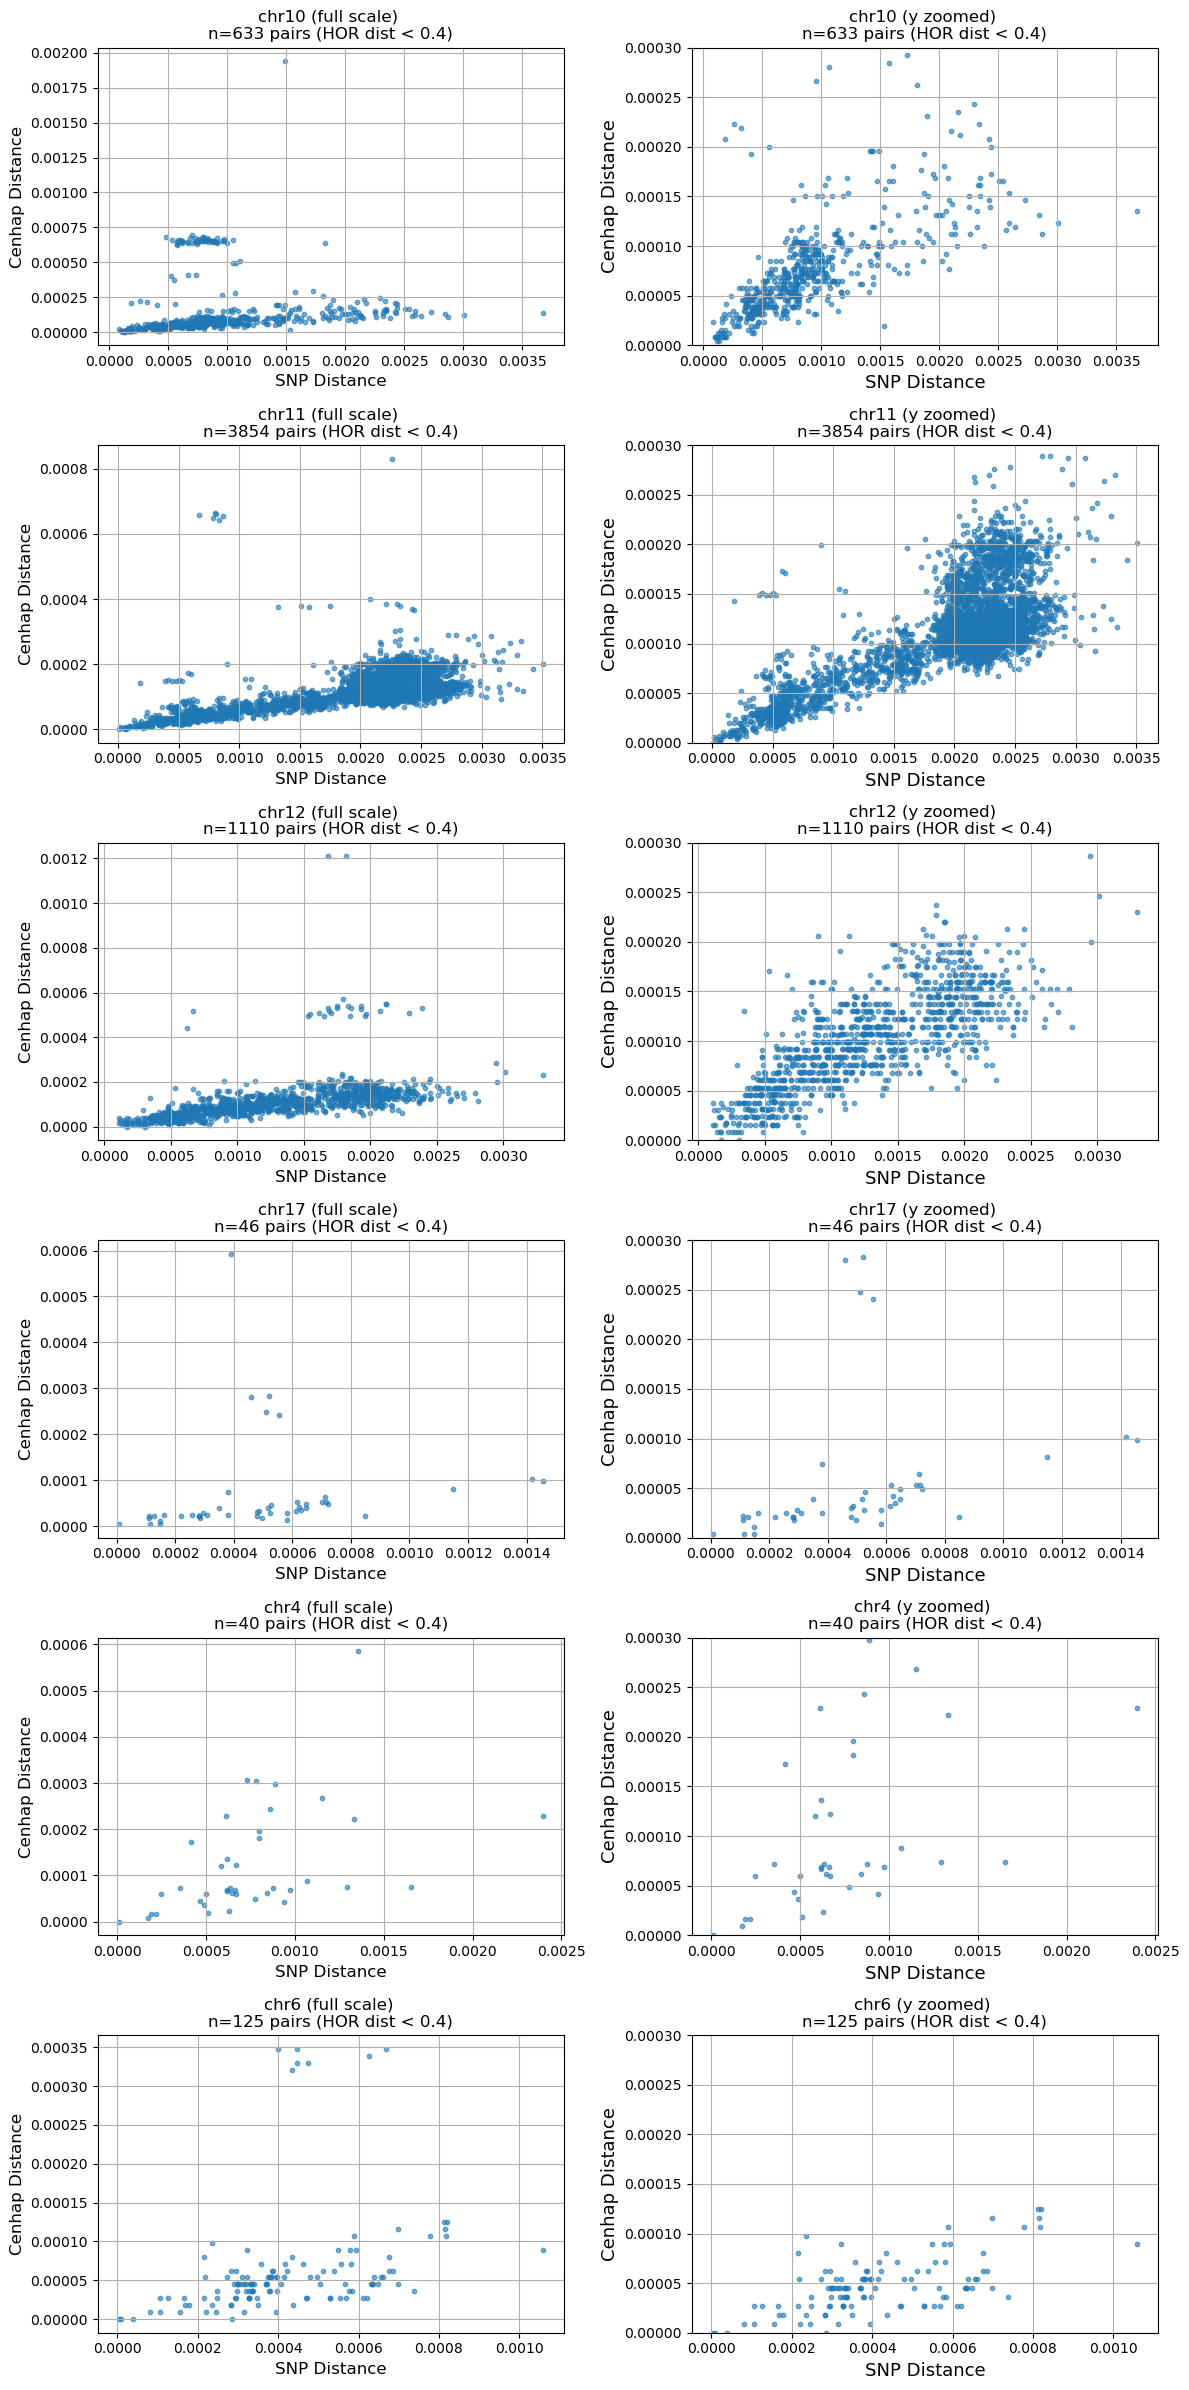

In [76]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Subset to specific chromosomes
selected_chrs = ["chr12", "chr11", "chr10"]
subset_df = merged_df[merged_df["chr"].isin(selected_chrs)]

# Filter only bin 0–0.2
bin_df = merged_df[(merged_df["dist_bin"] == "0–0.2") | (merged_df["dist_bin"] == "0.2–0.4")]


# List of chromosomes
chromosomes = sorted(bin_df["chr"].unique())
n_chrs = len(chromosomes)

# Create figure: one row per chromosome, 2 columns per row
fig, axes = plt.subplots(nrows=n_chrs, ncols=2, figsize=(12, 4*n_chrs))

# Ensure axes is 2D (nrows x ncols) for consistent indexing
if n_chrs == 1:
    axes = axes.reshape(1, 2)
elif n_chrs > 1:
    axes = np.array(axes)

for i, chr_name in enumerate(chromosomes):
    chr_df = bin_df[bin_df["chr"] == chr_name]

    # Count unique samples
    n_pairs = len(chr_df)

    # Full scale plot
    ax_full = axes[i, 0]
    ax_full.scatter(chr_df["snp_dist"], chr_df["cenhap_dist"], alpha=0.6, s=10)
    ax_full.set_xlabel("SNP Distance",fontsize=12)
    ax_full.set_ylabel("Cenhap Distance",fontsize=12)
    ax_full.set_title(f"{chr_name} (full scale) \nn={n_pairs} pairs (HOR dist < 0.4)")
    ax_full.grid(True)

    # Zoomed y-axis plot
    ax_zoom = axes[i, 1]
    ax_zoom.scatter(chr_df["snp_dist"], chr_df["cenhap_dist"], alpha=0.6, s=10)
    ax_zoom.set_xlabel("SNP Distance",fontsize=13)
    ax_zoom.set_ylabel("Cenhap Distance",fontsize=13)
    ax_zoom.set_title(f"{chr_name} (y zoomed) \nn={n_pairs} pairs (HOR dist < 0.4)")
    ax_zoom.set_ylim(0, 0.0003)
    ax_zoom.grid(True)

plt.tight_layout()
plt.show()

## Plot SV triangles rate versus SNP distance rate

In [18]:
## Load in SV dataframe 
df_sv_sorted = pd.read_parquet("/private/groups/patenlab/mira/centrolign/analysis/SVs_pairwise/all_chroms_SV_df.parquet")

df_sv_sorted.head()

,sample1,start1,end1,sample2,start2,end2,type,diff,clade,chr,source_file,length,pairwise_dist
0,HG002.1,963,11456,HG03742.2,963,964,D,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,10493,0.917844
1,HG002.1,13009,16731,HG03742.2,2516,2517,D,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,3722,0.917844
2,HG002.1,16882,16883,HG03742.2,2667,3006,I,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,339,0.917844
3,HG002.1,16924,17264,HG03742.2,3048,3049,D,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,340,0.917844
4,HG002.1,20842,23243,HG03742.2,6626,6627,D,0.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,2401,0.917844


In [19]:
## Add shape column 
### Add new column to dataframe classifying the "shape" category of each SV 

def classify_shape(diff):
    if diff == -1:
        return "triangle"
    elif 0 <= diff <= 0.1:
        return "parallelogram"
    elif diff > 0.1:
        return "trapezoid"
    else:
        return np.nan


In [20]:
df_sv_sorted["shape"]=df_sv_sorted["diff"].apply(classify_shape)
df_sv_sorted.head()

,sample1,start1,end1,sample2,start2,end2,type,diff,clade,chr,source_file,length,pairwise_dist,shape
0,HG002.1,963,11456,HG03742.2,963,964,D,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,10493,0.917844,triangle
1,HG002.1,13009,16731,HG03742.2,2516,2517,D,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,3722,0.917844,triangle
2,HG002.1,16882,16883,HG03742.2,2667,3006,I,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,339,0.917844,triangle
3,HG002.1,16924,17264,HG03742.2,3048,3049,D,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,340,0.917844,triangle
4,HG002.1,20842,23243,HG03742.2,6626,6627,D,0.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,2401,0.917844,parallelogram


In [21]:
# read in alpha sat array sizes

import pandas as pd
import os

# Path to the folder containing TSV files
folder_path = "/private/groups/migalab/juklucas/censat_regions/active_arrays"

# List all files in the folder
all_files = os.listdir(folder_path)

# Filter files matching asat_arrays_${chr}.tsv, exclude ones with "_raw"
tsv_files = [f for f in all_files if f.startswith("asat_arrays_") and f.endswith(".tsv") and "_raw" not in f]

all_dfs = []

for tsv_file in tsv_files:
    # Extract chr from filename using string split
    # Example: "asat_arrays_chr12.tsv" -> "chr12"
    chr_label = tsv_file.replace("asat_arrays_", "").replace(".tsv", "")

    # Build full path
    file_path = os.path.join(folder_path, tsv_file)

    # Read TSV
    df = pd.read_csv(file_path, sep="\t")

    # Keep only desired columns
    df = df[["asat_start", "asat_end", "sample_id", "haplotype"]].copy()

    # Create combined haplotype.assembly_id column
    df["sample"] = df["sample_id"].astype(str) + "." + df["haplotype"].astype(str)

    # Add chr column from filename
    df["chr"] = chr_label

    all_dfs.append(df)

# Concatenate all files into a single DataFrame
asat_df = pd.concat(all_dfs, ignore_index=True)

# Optional: keep only relevant columns
asat_df = asat_df[["asat_start", "asat_end", "sample", "chr"]]

print(asat_df.head())

   asat_start  asat_end     sample   chr
0    92070153  94778997  HG00097.1  chr2
1    92385520  94321652  HG00097.2  chr2
2    92130971  94547225  HG00099.1  chr2
3    92146667  94564932  HG00099.2  chr2
4    92601188  95044273  HG00126.1  chr2


In [22]:
## Plot # of SVs / avg asat array size between two samples for all chromosomes 
#df_induced_direct_combined.head()

# calculate asat length for each sample
asat_df["asat_length"] = asat_df["asat_end"] - asat_df["asat_start"]

# merge ASAT length for sample1
df_svs = df_sv_sorted.merge(
    asat_df.rename(columns={"sample": "sample1", "asat_length": "asat_len_1"}),
    on=["sample1", "chr"],
    how="left"
)

# merge ASAT length for sample2
df_svs = df_svs.merge(
    asat_df.rename(columns={"sample": "sample2", "asat_length": "asat_len_2"}),
    on=["sample2", "chr"],
    how="left"
)

df_svs = df_svs.drop('asat_start_x', axis=1)
df_svs = df_svs.drop('asat_start_y', axis=1)
df_svs = df_svs.drop('asat_end_x', axis=1)
df_svs = df_svs.drop('asat_end_y', axis=1)

df_svs.head()

,sample1,start1,end1,sample2,start2,end2,type,diff,clade,chr,source_file,length,pairwise_dist,shape,asat_len_1,asat_len_2
0,HG002.1,963,11456,HG03742.2,963,964,D,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,10493,0.917844,triangle,9485098,2869563
1,HG002.1,13009,16731,HG03742.2,2516,2517,D,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,3722,0.917844,triangle,9485098,2869563
2,HG002.1,16882,16883,HG03742.2,2667,3006,I,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,339,0.917844,triangle,9485098,2869563
3,HG002.1,16924,17264,HG03742.2,3048,3049,D,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,340,0.917844,triangle,9485098,2869563
4,HG002.1,20842,23243,HG03742.2,6626,6627,D,0.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,2401,0.917844,parallelogram,9485098,2869563


In [23]:
# Calculate # of SVs / avg asat array size per sample pair 
# result df holds one row per sample pair now 
import pandas as pd

# Create a sample_pair identifier
df_svs["sample_pair"] = df_svs["sample1"] + "_" + df_svs["sample2"]

# Group by chromosome, sample_pair, and shape
result = df_svs.groupby(['chr', 'sample1', 'sample2', 'shape']).agg(
    count_rows=('sample1', 'size'),       # number of rows in the group
    asat_len_1=('asat_len_1', 'first'),       # take first asat_len_1
    asat_len_2=('asat_len_2', 'first'),       # take first asat_len_2
    pairwise_dist=('pairwise_dist', 'first')  # take first pairwise_dist
).reset_index()

# Compute mean of asat_len_1 and asat_len_2
result['mean_asat_len'] = (result['asat_len_1'] + result['asat_len_2']) / 2

# Divide count by mean_asat_len
result['sv_rate'] = result['count_rows'] / result['mean_asat_len']

# Optional: drop intermediate asat_len columns if you don't need them
result = result.drop(columns=['asat_len_1', 'asat_len_2'])

print(len(result))

1393615


In [25]:
# merge SV rate df with SNP distance dataframe 
SV_snp_rate_merged_df = pd.merge(
    result,
    snp_dist_df,
    on=["sample1", "sample2", "chr"],
    how="left"   # or "inner" if you only want matching rows
)


bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
bin_labels = ["0–0.2", "0.2–0.4", "0.4–0.6", "0.6–0.8", "0.8–1.0"]

# Add a new column for the bin
SV_snp_rate_merged_df["dist_bin"] = pd.cut(SV_snp_rate_merged_df["pairwise_dist"], bins=bins, labels=bin_labels, include_lowest=True)

SV_snp_rate_merged_df.head()

,chr,sample1,sample2,shape,count_rows,pairwise_dist,mean_asat_len,sv_rate,snp_dist,dist_bin
0,chr1,CHM13.0,HG00099.2,parallelogram,66,0.718038,4104985.5,0.000016,0.008503,0.6–0.8
1,chr1,CHM13.0,HG00099.2,trapezoid,347,0.718038,4104985.5,0.000085,0.008503,0.6–0.8
2,chr1,CHM13.0,HG00099.2,triangle,277,0.718038,4104985.5,0.000067,0.008503,0.6–0.8
3,chr1,CHM13.0,HG00126.2,parallelogram,38,0.455102,3740711.0,0.000010,0.003211,0.4–0.6
4,chr1,CHM13.0,HG00126.2,trapezoid,122,0.455102,3740711.0,0.000033,0.003211,0.4–0.6


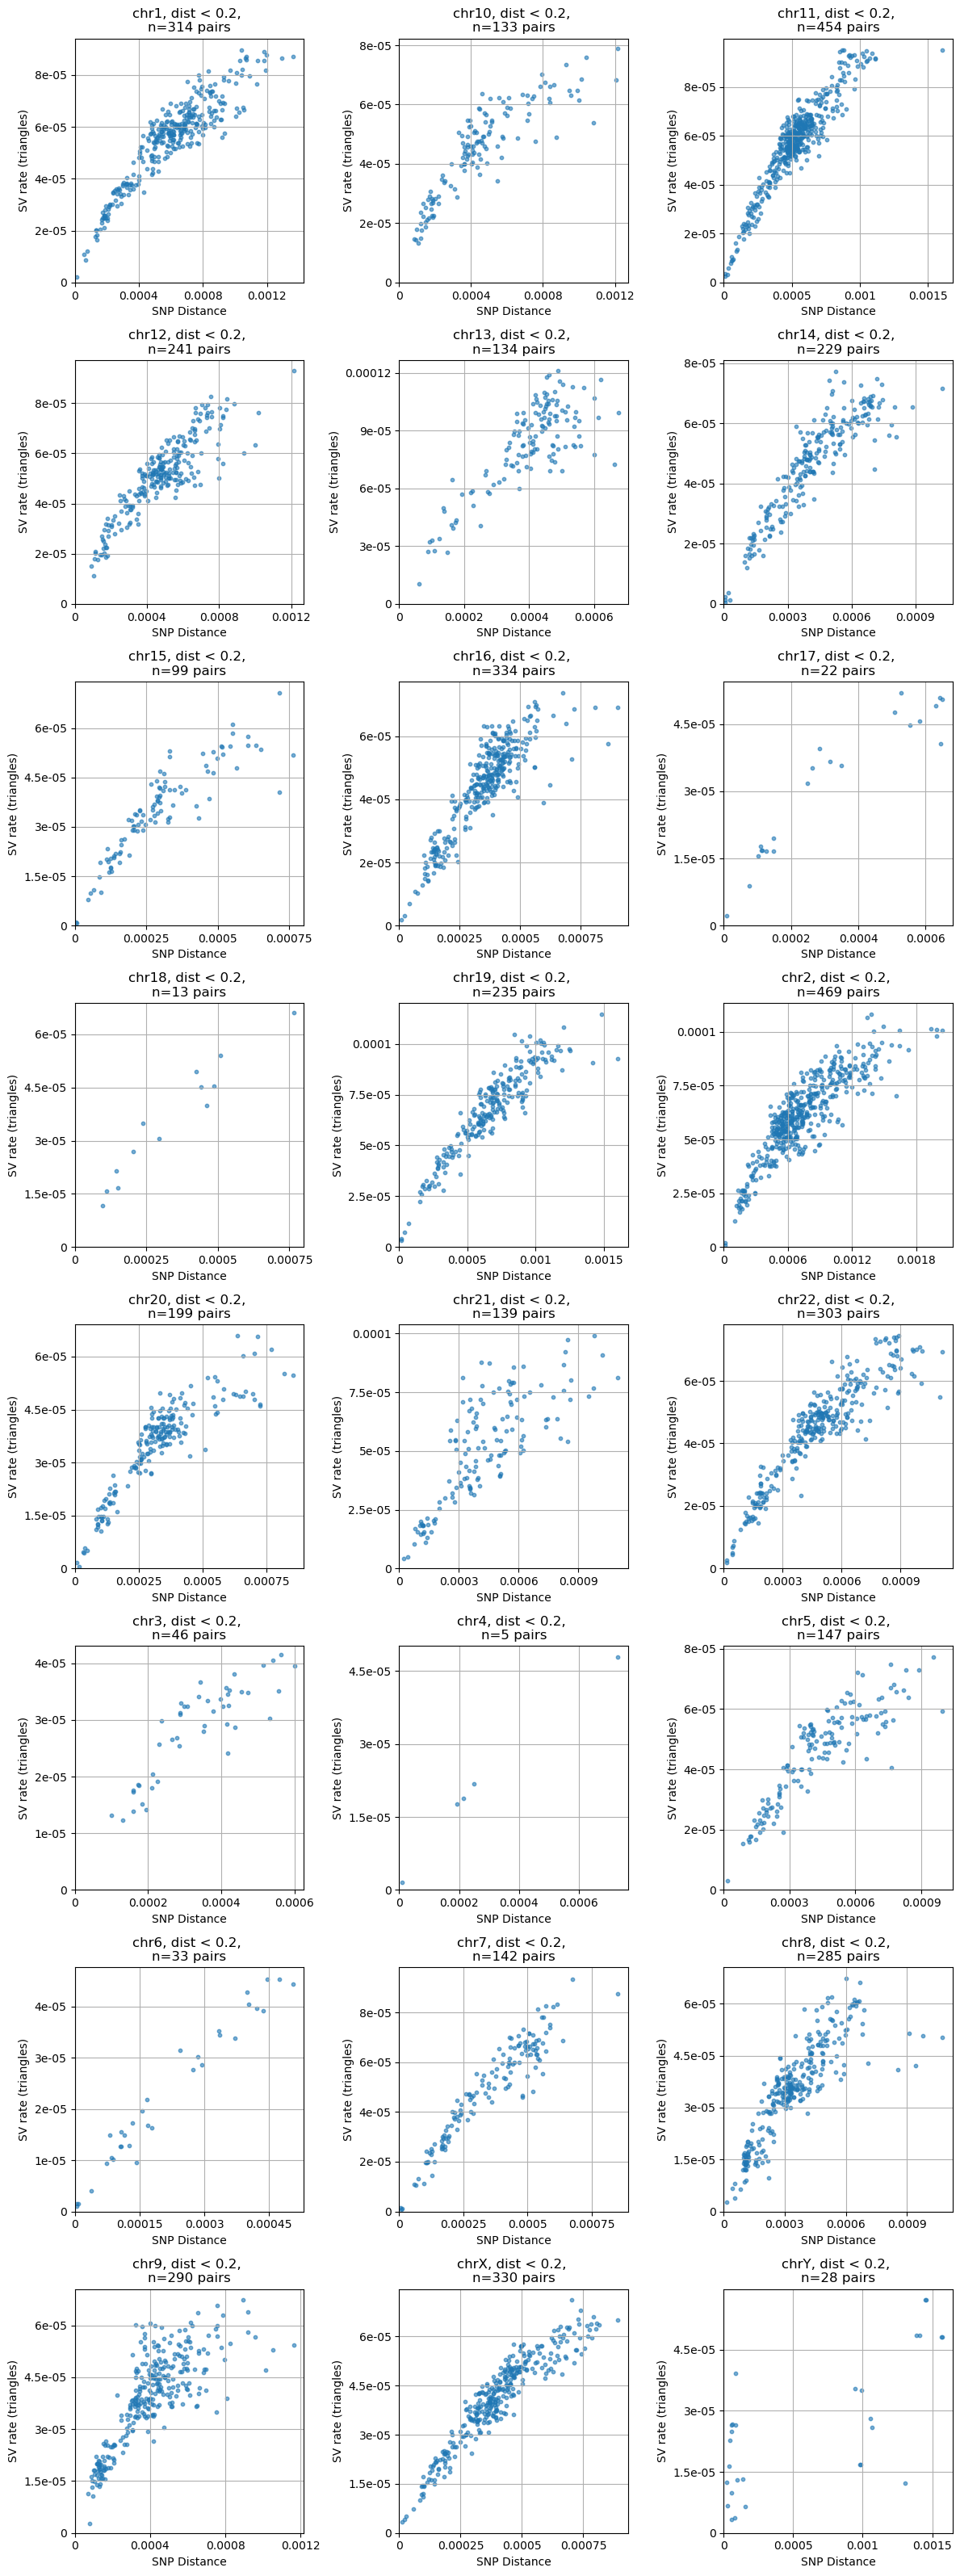

In [105]:
### Plot SV triangle rate vs SNP distance rate 
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mticker
from matplotlib.ticker import MaxNLocator, FormatStrFormatter

# Step 1: filter the dataframe
filtered_df = SV_snp_rate_merged_df[
    (SV_snp_rate_merged_df["shape"] == "triangle") &
    (SV_snp_rate_merged_df["pairwise_dist"] < 0.2)
]

# Step 2: get sorted list of chromosomes
chromosomes = sorted(filtered_df["chr"].unique())
n_chrs = len(chromosomes)

# Step 3: create figure with 4 plots per row
n_cols = 3
n_rows = int(np.ceil(n_chrs / n_cols))
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(4*n_cols, 4*n_rows), squeeze=False)

# Step 4: plot each chromosome
for idx, chr_name in enumerate(chromosomes):
    row = idx // n_cols
    col = idx % n_cols
    ax = axes[row, col]

    chr_df = filtered_df[filtered_df["chr"] == chr_name]
    ax.scatter(chr_df["snp_dist"], chr_df["sv_rate"], alpha=0.6, s=10)
    ax.set_title(f"{chr_name}, dist < 0.2, \nn={len(chr_df)} pairs", fontsize=12)
    ax.set_xlabel("SNP Distance", fontsize=10)
    ax.set_ylabel("SV rate (triangles)", fontsize=10)
    ax.grid(True)

    # Force axes to start at 0
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)


    ax.xaxis.set_major_locator(MaxNLocator(nbins=4))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=5))

    ax.xaxis.set_major_formatter(FormatStrFormatter('%.3g'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.3g'))


# Step 5: remove unused subplots
for idx in range(n_chrs, n_rows*n_cols):
    row = idx // n_cols
    col = idx % n_cols
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()


### Plot short indel rate versus SNP distance rate

In [6]:
### This function reads in the SV bed files into a pandas DF for a given clade. 

def read_sv_bed_files(clade, chr, bed_folder):
    """
    Read all .bed files in a folder and add a 'clade' column to the data frame
    Each bed file has columns:
        sample1, start, end, sample2, start, end, type, diff
    """
    all_beds = []
    bed_files = [f for f in os.listdir(bed_folder) if f.endswith(".bed")]
    print(f"Found {len(bed_files)} SV bed files for clade '{clade}'")

    # Ensure folder exists
    if not os.path.isdir(bed_folder):
        raise FileNotFoundError("Folder not found for clade '{}': {}".format(clade, bed_folder))

    for filename in os.listdir(bed_folder):
        if filename.endswith(".bed"):
            bed_path = os.path.join(bed_folder, filename)
            try:
                df = pd.read_csv(
                    bed_path,
                    sep="\t",
                    header=None,
                    names=["sample1", "start1", "end1", "sample2", "start2", "end2", "type", "diff"]
                )
                df["clade"] = clade
                df["chr"] = chr
                df["source_file"] = filename  # optional, helps track origin
                df["length"] = np.where(
                    df["type"] == "I",
                    df["end2"] - df["start2"],  # insertion → use sample2 coords
                    df["end1"] - df["start1"]  # otherwise (deletion) → sample1 coords
                )
                all_beds.append(df)
            except Exception as e:
                print("Warning: Could not read {}: {}".format(bed_path, e))

    if all_beds: 
        return pd.concat(all_beds, ignore_index=True)
    else:
        print("Warning: No .bed files found in {} for clade '{}'".format(bed_folder, clade))
        return pd.DataFrame(columns=["sample1", "start1", "end1", "sample2", "start2", "end2", "type", "diff", "clade", "source_file","chr"])

In [ ]:
### read in short indels to python dataframe

### For all clades in provided input csv, read SVs into dataframe and merge 
input_csv="/private/groups/patenlab/mira/centrolign/analysis/short_indels_pairwise/12142025_clade_chr_short_indel_beds.csv"

clade_info = pd.read_csv(input_csv)
if not {"clade", "chr","path_to_SV_beds"}.issubset(clade_info.columns):
    raise ValueError("Input CSV must contain columns: 'clade' and 'chr' and 'path_to_SV_beds'")

#clade_info_subset= clade_info.head(6)

all_data = []

for _, row in clade_info.iterrows():
    clade = str(row["clade"])
    chr = str(row["chr"])
    bed_folder = str(row["path_to_SV_beds"])
    df = read_sv_bed_files(clade, chr, bed_folder)
    if not df.empty:
        all_data.append(df)

if all_data:
    merged_df = pd.concat(all_data, ignore_index=True)

    #print("=== Head of merged DataFrame ===")
    #(merged_df.head(), "\n")

    # Print count of rows per clade
    print("=== Record count per clade ===")
    print(merged_df["clade"].value_counts())

In [ ]:
# save short indel df file 
merged_df.to_parquet("/private/groups/patenlab/mira/centrolign/analysis/SVs_pairwise/short_indels_merged_df.parquet")

In [6]:
# read in short indel df 
df_short_indel = pd.read_parquet("/private/groups/patenlab/mira/centrolign/analysis/SVs_pairwise/short_indels_merged_df.parquet")
df_short_indel.head()

,sample1,start1,end1,sample2,start2,end2,type,diff,clade,chr,source_file,length
0,HG002.1,27341,27342,HG03742.2,15844,15845,D,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,1
1,HG002.1,31652,31656,HG03742.2,19813,19814,D,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,4
2,HG002.1,34426,34427,HG03742.2,29030,29031,I,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,1
3,HG002.1,34432,34433,HG03742.2,29037,29038,D,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,1
4,HG002.1,34436,34438,HG03742.2,29040,29041,D,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,2


In [7]:
# add column labelling each row with a shape 
df_short_indel["shape"]=df_short_indel["diff"].apply(classify_shape)
df_short_indel.head()

,sample1,start1,end1,sample2,start2,end2,type,diff,clade,chr,source_file,length,shape
0,HG002.1,27341,27342,HG03742.2,15844,15845,D,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,1,triangle
1,HG002.1,31652,31656,HG03742.2,19813,19814,D,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,4,triangle
2,HG002.1,34426,34427,HG03742.2,29030,29031,I,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,1,triangle
3,HG002.1,34432,34433,HG03742.2,29037,29038,D,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,1,triangle
4,HG002.1,34436,34438,HG03742.2,29040,29041,D,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,2,triangle


In [8]:
## merge with asat length dataframe

# calculate asat length for each sample
asat_df["asat_length"] = asat_df["asat_end"] - asat_df["asat_start"]

# merge ASAT length for sample1
df_short_indel = df_short_indel.merge(
    asat_df.rename(columns={"sample": "sample1", "asat_length": "asat_len_1"}),
    on=["sample1", "chr"],
    how="left"
)

# merge ASAT length for sample2
df_short_indel = df_short_indel.merge(
    asat_df.rename(columns={"sample": "sample2", "asat_length": "asat_len_2"}),
    on=["sample2", "chr"],
    how="left"
)

df_short_indel = df_short_indel.drop('asat_start_x', axis=1)
df_short_indel = df_short_indel.drop('asat_start_y', axis=1)
df_short_indel = df_short_indel.drop('asat_end_x', axis=1)
df_short_indel = df_short_indel.drop('asat_end_y', axis=1)

df_short_indel.head()

,sample1,start1,end1,sample2,start2,end2,type,diff,clade,chr,source_file,length,shape,asat_len_1,asat_len_2
0,HG002.1,27341,27342,HG03742.2,15844,15845,D,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,1,triangle,9485098,2869563
1,HG002.1,31652,31656,HG03742.2,19813,19814,D,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,4,triangle,9485098,2869563
2,HG002.1,34426,34427,HG03742.2,29030,29031,I,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,1,triangle,9485098,2869563
3,HG002.1,34432,34433,HG03742.2,29037,29038,D,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,1,triangle,9485098,2869563
4,HG002.1,34436,34438,HG03742.2,29040,29041,D,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,2,triangle,9485098,2869563


In [ ]:
# Calculate # of short indels / avg asat array size per sample pair 
# result df holds one row per sample pair now 

# Group by chromosome, sample_pair, and shape
result2 = df_short_indel.groupby(['chr', 'sample1', 'sample2', 'shape']).agg(
    count_rows=('sample1', 'size'),       # number of rows in the group
    asat_len_1=('asat_len_1', 'first'),       # take first asat_len_1
    asat_len_2=('asat_len_2', 'first')       # take first asat_len_2
).reset_index()

# Compute mean of asat_len_1 and asat_len_2
result2['mean_asat_len'] = (result2['asat_len_1'] + result2['asat_len_2']) / 2

# Divide count by mean_asat_len
result2['short_indel_rate'] = result2['count_rows'] / result2['mean_asat_len']

# Optional: drop intermediate asat_len columns if you don't need them
result2 = result2.drop(columns=['asat_len_1', 'asat_len_2'])

print(result2)

          chr    sample1    sample2          shape  count_rows  mean_asat_len  \
0        chr1    CHM13.0  HG00099.2  parallelogram           4      4104985.5   
1        chr1    CHM13.0  HG00099.2      trapezoid          77      4104985.5   
2        chr1    CHM13.0  HG00099.2       triangle         350      4104985.5   
3        chr1    CHM13.0  HG00126.2  parallelogram           2      3740711.0   
4        chr1    CHM13.0  HG00126.2      trapezoid          36      3740711.0   
...       ...        ...        ...            ...         ...            ...   
1097461  chrY  NA21093.1  HG02083.1      trapezoid           2       568735.0   
1097462  chrY  NA21093.1  HG02083.1       triangle           2       568735.0   
1097463  chrY  NA21093.1  HG02735.1      trapezoid           5       607365.5   
1097464  chrY  NA21093.1  HG02735.1       triangle           7       607365.5   
1097465  chrY  NA21093.1  NA20762.1       triangle           2       766538.5   

         short_indel_rate  

In [38]:
# Merge df with pairwise distance df 

# Create a sample_pair identifier before merging on sample1,sample2, chr
result2["sample_pair"] = (
    result2[["sample1", "sample2"]]
    .apply(lambda x: "_".join(sorted(x)), axis=1)
)

all_pairs_dist_df["sample_pair"] = (
    all_pairs_dist_df[["sample1", "sample2"]]
    .apply(lambda x: "_".join(sorted(x)), axis=1)
)

merged_result2_df = pd.merge(
    result2,
    all_pairs_dist_df,
    on=["sample_pair", "chr"],
    how="left"   # or "inner" if you only want matching rows
)

merged_result2_df = merged_result2_df.drop('sample1_y', axis=1)
merged_result2_df = merged_result2_df.drop('sample2_y', axis=1)
merged_result2_df = merged_result2_df.rename(columns={
    "sample1_x": "sample1",
    "sample2_x": "sample2"
})

merged_result2_df.head()

,chr,sample1,sample2,shape,count_rows,mean_asat_len,short_indel_rate,sample_pair,direct_pairwise_dist
0,chr1,CHM13.0,HG00099.2,parallelogram,4,4104985.5,9.744249e-07,CHM13.0_HG00099.2,0.718038
1,chr1,CHM13.0,HG00099.2,trapezoid,77,4104985.5,1.875768e-05,CHM13.0_HG00099.2,0.718038
2,chr1,CHM13.0,HG00099.2,triangle,350,4104985.5,8.526218e-05,CHM13.0_HG00099.2,0.718038
3,chr1,CHM13.0,HG00126.2,parallelogram,2,3740711.0,5.346577e-07,CHM13.0_HG00126.2,0.455102
4,chr1,CHM13.0,HG00126.2,trapezoid,36,3740711.0,9.623839e-06,CHM13.0_HG00126.2,0.455102


In [40]:
# merge SV rate df with SNP distance dataframe 

# Create a sample_pair identifier before merging on sample1,sample2, chr
snp_dist_df["sample_pair"] = (
    snp_dist_df[["sample1", "sample2"]]
    .apply(lambda x: "_".join(sorted(x)), axis=1)
)

short_indel_snp_rate_merged_df = pd.merge(
    merged_result2_df,
    snp_dist_df,
    on=["sample_pair", "chr"],
    how="left"   # or "inner" if you only want matching rows
)

short_indel_snp_rate_merged_df = short_indel_snp_rate_merged_df.drop('sample1_y', axis=1)
short_indel_snp_rate_merged_df = short_indel_snp_rate_merged_df.drop('sample2_y', axis=1)
short_indel_snp_rate_merged_df = short_indel_snp_rate_merged_df.rename(columns={
    "sample1_x": "sample1",
    "sample2_x": "sample2"
})

bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
bin_labels = ["0–0.2", "0.2–0.4", "0.4–0.6", "0.6–0.8", "0.8–1.0"]

# Add a new column for the bin
short_indel_snp_rate_merged_df["dist_bin"] = pd.cut(short_indel_snp_rate_merged_df["direct_pairwise_dist"], bins=bins, labels=bin_labels, include_lowest=True)

short_indel_snp_rate_merged_df.head()

,chr,sample1,sample2,shape,count_rows,mean_asat_len,short_indel_rate,sample_pair,direct_pairwise_dist,snp_dist,dist_bin
0,chr1,CHM13.0,HG00099.2,parallelogram,4,4104985.5,9.744249e-07,CHM13.0_HG00099.2,0.718038,0.008503,0.6–0.8
1,chr1,CHM13.0,HG00099.2,trapezoid,77,4104985.5,1.875768e-05,CHM13.0_HG00099.2,0.718038,0.008503,0.6–0.8
2,chr1,CHM13.0,HG00099.2,triangle,350,4104985.5,8.526218e-05,CHM13.0_HG00099.2,0.718038,0.008503,0.6–0.8
3,chr1,CHM13.0,HG00126.2,parallelogram,2,3740711.0,5.346577e-07,CHM13.0_HG00126.2,0.455102,0.003211,0.4–0.6
4,chr1,CHM13.0,HG00126.2,trapezoid,36,3740711.0,9.623839e-06,CHM13.0_HG00126.2,0.455102,0.003211,0.4–0.6


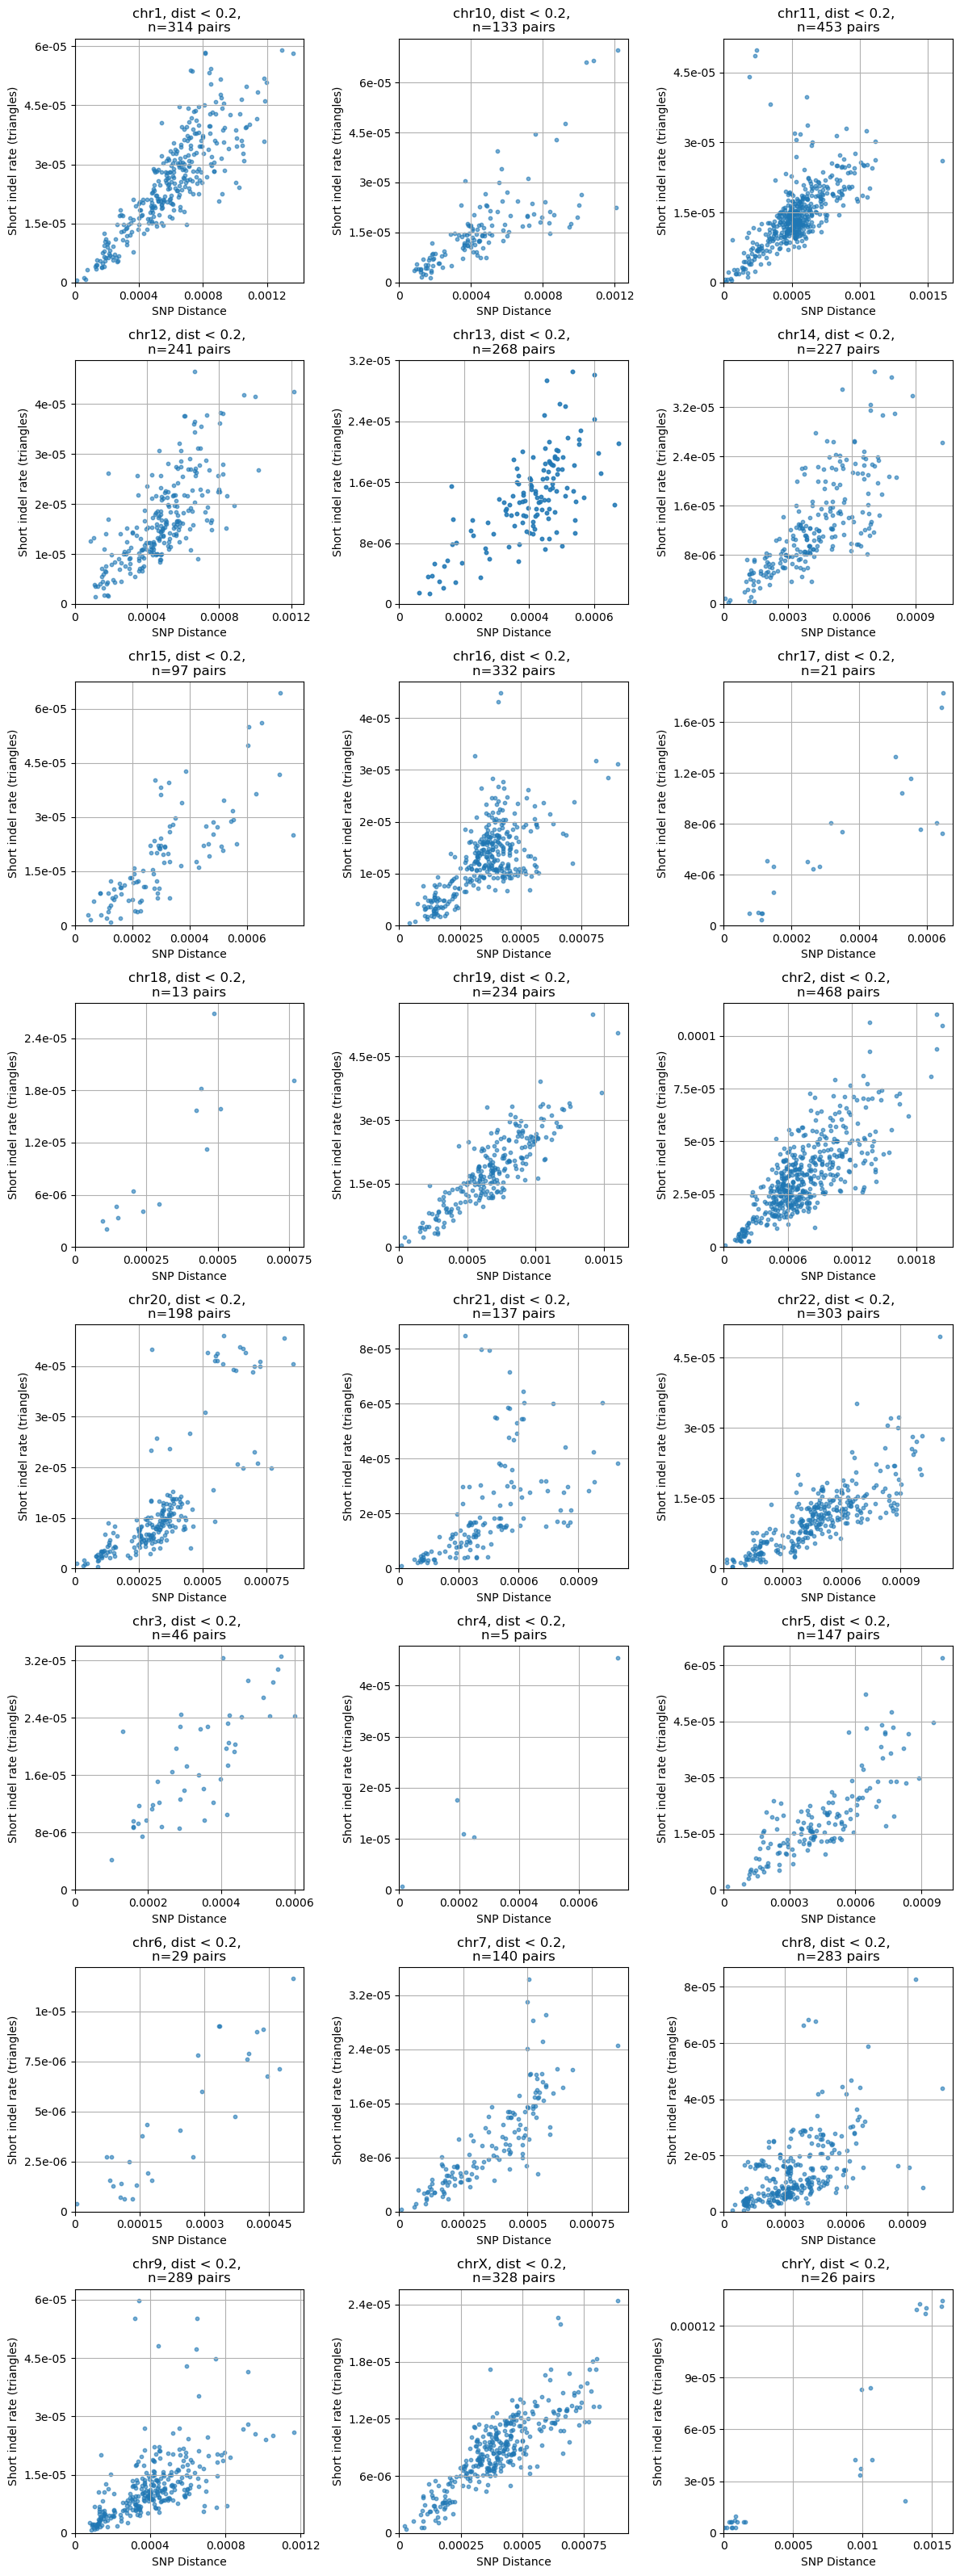

In [42]:
### Plot short indel rate vs SNP distance rate 
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mticker
from matplotlib.ticker import MaxNLocator, FormatStrFormatter

# Step 1: filter the dataframe
filtered_df = short_indel_snp_rate_merged_df[
    (short_indel_snp_rate_merged_df["shape"] == "triangle") &
    (short_indel_snp_rate_merged_df["direct_pairwise_dist"] < 0.2)
]

# Step 2: get sorted list of chromosomes
chromosomes = sorted(filtered_df["chr"].unique())
n_chrs = len(chromosomes)

# Step 3: create figure with 4 plots per row
n_cols = 3
n_rows = int(np.ceil(n_chrs / n_cols))
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(4*n_cols, 4*n_rows), squeeze=False)

# Step 4: plot each chromosome
for idx, chr_name in enumerate(chromosomes):
    row = idx // n_cols
    col = idx % n_cols
    ax = axes[row, col]

    chr_df = filtered_df[filtered_df["chr"] == chr_name]
    ax.scatter(chr_df["snp_dist"], chr_df["short_indel_rate"], alpha=0.6, s=10)
    ax.set_title(f"{chr_name}, dist < 0.2, \nn={len(chr_df)} pairs", fontsize=12)
    ax.set_xlabel("SNP Distance", fontsize=10)
    ax.set_ylabel("Short indel rate (triangles)", fontsize=10)
    ax.grid(True)

    # Force axes to start at 0
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)


    ax.xaxis.set_major_locator(MaxNLocator(nbins=4))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=5))

    ax.xaxis.set_major_formatter(FormatStrFormatter('%.3g'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.3g'))


# Step 5: remove unused subplots
for idx in range(n_chrs, n_rows*n_cols):
    row = idx // n_cols
    col = idx % n_cols
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()


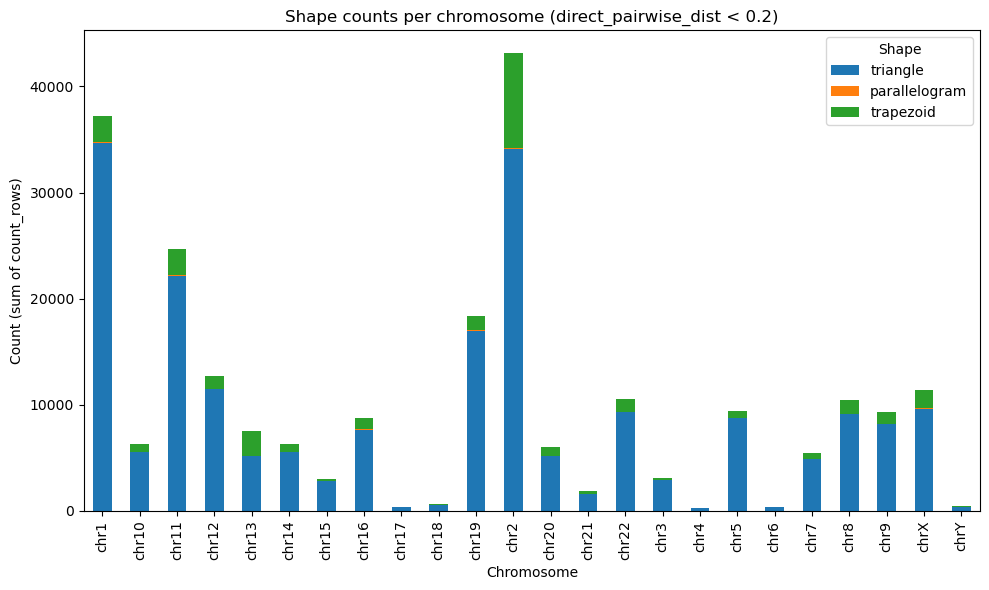

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

# Shapes to include (order matters for stacking)
shapes = ["triangle", "parallelogram", "trapezoid"]

# Filter by distance
df_filt = short_indel_snp_rate_merged_df[short_indel_snp_rate_merged_df["direct_pairwise_dist"] < 0.2]

# Sum count_rows per chr and shape
counts = (
    df_filt[df_filt["shape"].isin(shapes)]
    .groupby(["chr", "shape"])["count_rows"]
    .sum()
    .unstack(fill_value=0)
)

# Ensure all shapes are present as columns
counts = counts.reindex(columns=shapes, fill_value=0)

# -----------------------------
# Plot stacked bar plot
# -----------------------------
ax = counts.plot(
    kind="bar",
    stacked=True,
    figsize=(10, 6)
)

ax.set_xlabel("Chromosome")
ax.set_ylabel("Count (sum of count_rows)")
ax.set_title("Shape counts per chromosome (direct_pairwise_dist < 0.2)")
ax.legend(title="Shape")

plt.tight_layout()
plt.show()


## Comparing active array filtered SNV rate to cenhap rate 

In [6]:
# Read in Julian's filtered SNV summary tables for filters with 95 percentile, 500 bp away from an indel 

# Path pattern for all chromosome summary files
pattern = "/private/groups/migalab/juklucas/centrolign/variant_calling/rates/chr*/chr*_summary.csv"

# Find all matching files
files = glob.glob(pattern)

# Read and concatenate into a single DataFrame
filtered_500bp_df = pd.concat(
    (pd.read_csv(f) for f in files),
    ignore_index=True
)

filtered_500bp_df["filtered_rate"] = np.where(
    filtered_500bp_df["aligned_bp"] > 0,
    filtered_500bp_df["n_snvs_filtered"] / filtered_500bp_df["aligned_bp"],
    np.nan
)

filtered_500bp_df.rename(columns={"sample_a": "sample1"}, inplace=True)
filtered_500bp_df.rename(columns={"sample_b": "sample2"}, inplace=True)
filtered_500bp_df.rename(columns={"chrom": "chr"}, inplace=True)

print(filtered_500bp_df.head())
print(f"Loaded {len(files)} files, {len(filtered_500bp_df)} rows total")

     chr    sample1    sample2  distance  n_snvs  n_snvs_filtered  \
0  chr11  HG01123.1  HG01993.1  0.364401    4150             2846   
1  chr11  HG01993.1  HG01123.1  0.364401    4150             2819   
2  chr11  HG01123.1  HG04228.1  0.355937    3547             2710   
3  chr11  HG04228.1  HG01123.1  0.355937    3547             2585   
4  chr11  HG01123.1  NA18944.2  0.378571    3363             2324   

   n_alignment_blocks  aligned_bp  filtered_rate  
0                 261     1785876       0.001594  
1                 294     1785876       0.001578  
2                 210     1688837       0.001605  
3                 267     1688837       0.001531  
4                 241     1637286       0.001419  
Loaded 24 files, 76088 rows total


In [7]:
# Merge the snp dist and cenhap dist data frames 

merged_df_filt = pd.merge(
    cenhap_dists,
    filtered_500bp_df,
    on=["sample1", "sample2", "chr"],
    how="inner"   # or "inner" if you only want matching rows
)

# now merge in the all pairs distances
merged_df_filt = pd.merge(
    merged_df_filt,
    all_pairs_dist_df,
    on=["sample1", "sample2", "chr"],
    how="inner"   # or "inner" if you only want matching rows
)



# add distance bins 

bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
bin_labels = ["0–0.2", "0.2–0.4", "0.4–0.6", "0.6–0.8", "0.8–1.0"]

# Add a new column for the bin
merged_df_filt["dist_bin"] = pd.cut(merged_df_filt["direct_pairwise_dist"], bins=bins, labels=bin_labels, include_lowest=True)

merged_df_filt.head()

,sample1,sample2,cenhap_dist,source_file,chr,distance,n_snvs,n_snvs_filtered,n_alignment_blocks,aligned_bp,filtered_rate,direct_pairwise_dist,dist_bin
0,CHM13.0,HG00290.2,0.000078,/private/groups/patenlab/mira/centrolign/annot...,chr11,0.352703,3540,2399,326,2338403,0.001026,0.352703,0.2–0.4
1,CHM13.0,HG00320.1,0.000004,/private/groups/patenlab/mira/centrolign/annot...,chr11,0.103863,503,390,70,3012748,0.000129,0.103863,0–0.2
2,CHM13.0,HG00320.2,0.000007,/private/groups/patenlab/mira/centrolign/annot...,chr11,0.099150,483,373,66,3031784,0.000123,0.099150,0–0.2
3,CHM13.0,HG00733.2,0.000035,/private/groups/patenlab/mira/centrolign/annot...,chr11,0.391248,1624,1163,130,1993770,0.000583,0.391248,0.2–0.4
4,CHM13.0,HG01081.2,0.000041,/private/groups/patenlab/mira/centrolign/annot...,chr11,0.306187,1807,1360,176,2471913,0.000550,0.306187,0.2–0.4


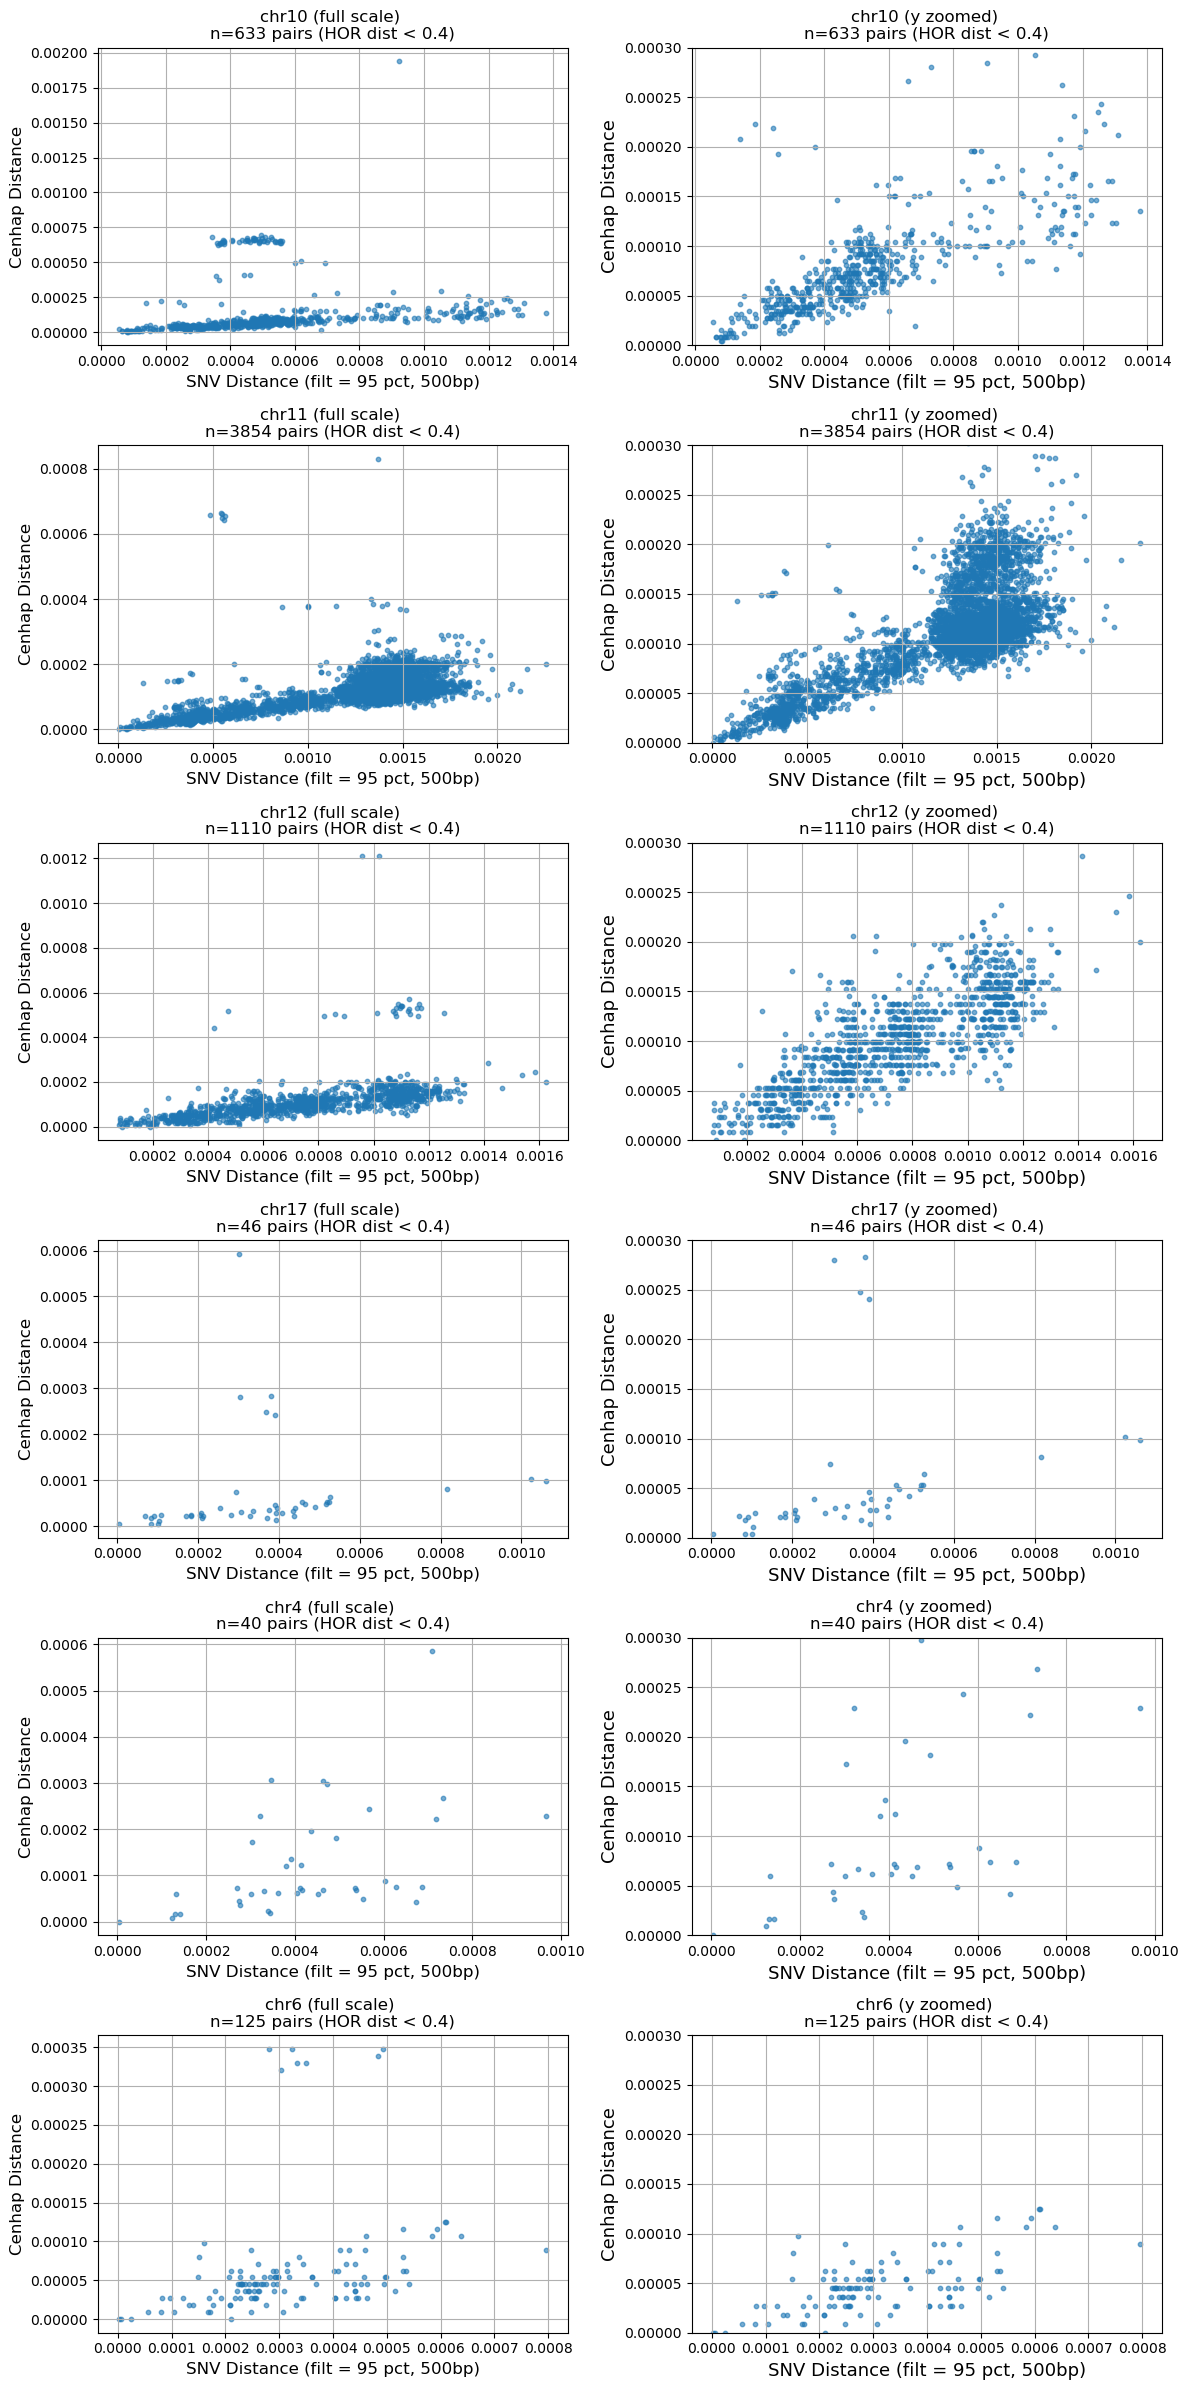

In [8]:
### Plot filtered SNV rate versus cenhap distance 

# Subset to specific chromosomes
selected_chrs = ["chr12", "chr11", "chr10"]
subset_df = merged_df_filt[merged_df_filt["chr"].isin(selected_chrs)]

# Filter only bin 0–0.2
bin_df = merged_df_filt[(merged_df_filt["dist_bin"] == "0–0.2") | (merged_df_filt["dist_bin"] == "0.2–0.4")]


# List of chromosomes
chromosomes = sorted(bin_df["chr"].unique())
n_chrs = len(chromosomes)

# Create figure: one row per chromosome, 2 columns per row
fig, axes = plt.subplots(nrows=n_chrs, ncols=2, figsize=(12, 4*n_chrs))

# Ensure axes is 2D (nrows x ncols) for consistent indexing
if n_chrs == 1:
    axes = axes.reshape(1, 2)
elif n_chrs > 1:
    axes = np.array(axes)

for i, chr_name in enumerate(chromosomes):
    chr_df = bin_df[bin_df["chr"] == chr_name]

    # Count unique samples
    n_pairs = len(chr_df)

    # Full scale plot
    ax_full = axes[i, 0]
    ax_full.scatter(chr_df["filtered_rate"], chr_df["cenhap_dist"], alpha=0.6, s=10)
    ax_full.set_xlabel("SNV Distance (filt = 95 pct, 500bp)",fontsize=12)
    ax_full.set_ylabel("Cenhap Distance",fontsize=12)
    ax_full.set_title(f"{chr_name} (full scale) \nn={n_pairs} pairs (HOR dist < 0.4)")
    ax_full.grid(True)

    # Zoomed y-axis plot
    ax_zoom = axes[i, 1]
    ax_zoom.scatter(chr_df["filtered_rate"], chr_df["cenhap_dist"], alpha=0.6, s=10)
    ax_zoom.set_xlabel("SNV Distance (filt = 95 pct, 500bp)",fontsize=13)
    ax_zoom.set_ylabel("Cenhap Distance",fontsize=13)
    ax_zoom.set_title(f"{chr_name} (y zoomed) \nn={n_pairs} pairs (HOR dist < 0.4)")
    ax_zoom.set_ylim(0, 0.0003)
    ax_zoom.grid(True)

plt.tight_layout()
plt.show()

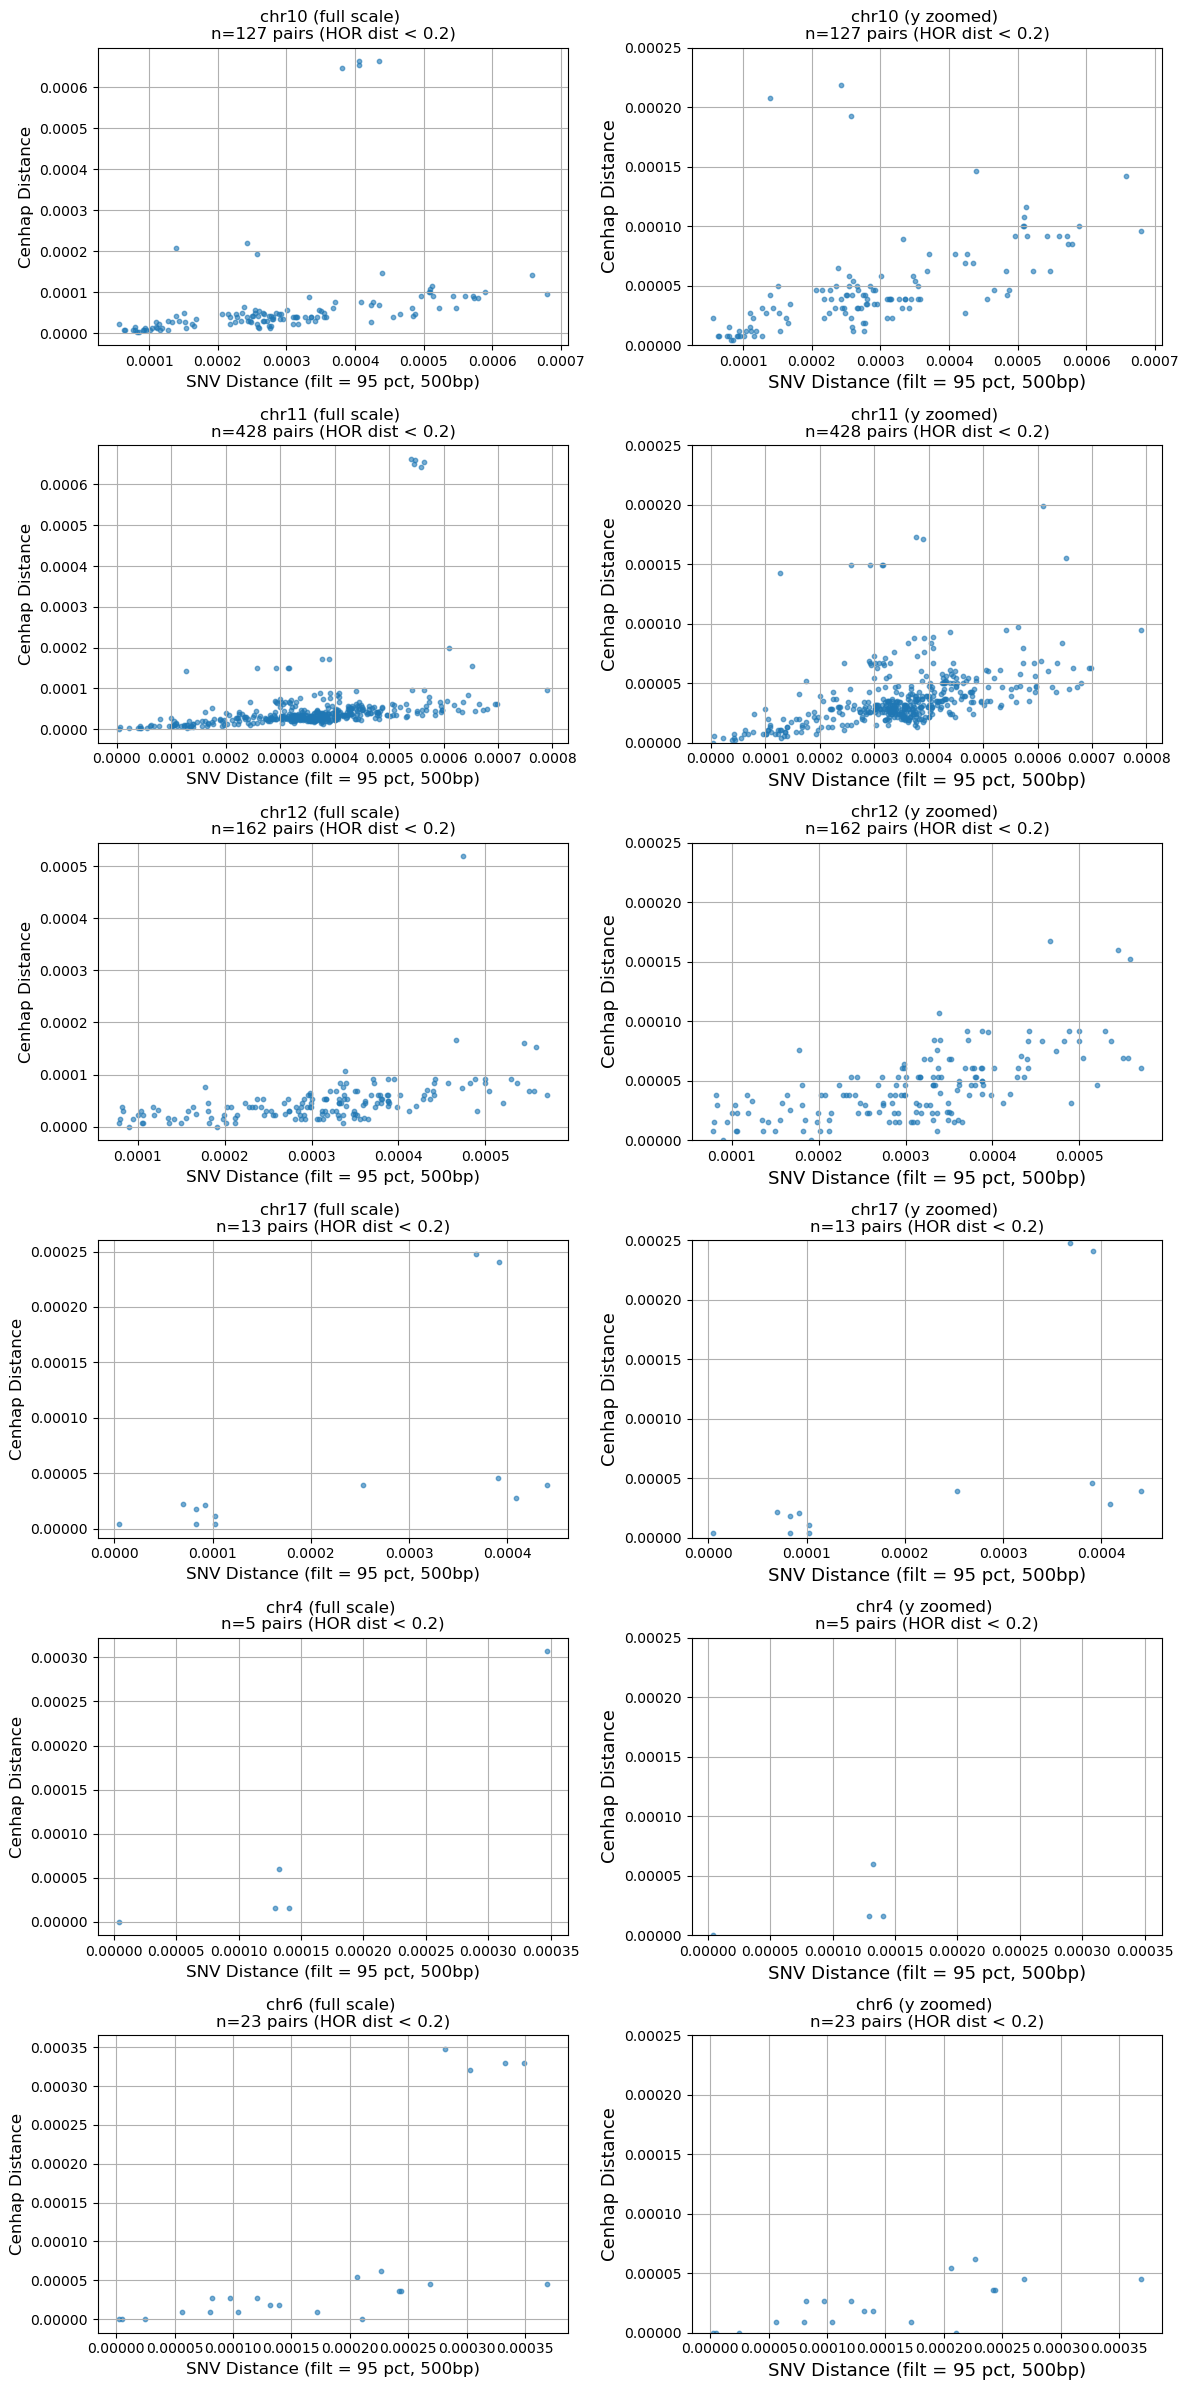

In [10]:
### Plot filtered SNV rate versus cenhap distance 

# Subset to specific chromosomes
selected_chrs = ["chr12", "chr11", "chr10"]
subset_df = merged_df_filt[merged_df_filt["chr"].isin(selected_chrs)]

# Filter only bin 0–0.2
bin_df = merged_df_filt[(merged_df_filt["dist_bin"] == "0–0.2")]


# List of chromosomes
chromosomes = sorted(bin_df["chr"].unique())
n_chrs = len(chromosomes)

# Create figure: one row per chromosome, 2 columns per row
fig, axes = plt.subplots(nrows=n_chrs, ncols=2, figsize=(12, 4*n_chrs))

# Ensure axes is 2D (nrows x ncols) for consistent indexing
if n_chrs == 1:
    axes = axes.reshape(1, 2)
elif n_chrs > 1:
    axes = np.array(axes)

for i, chr_name in enumerate(chromosomes):
    chr_df = bin_df[bin_df["chr"] == chr_name]

    # Count unique samples
    n_pairs = len(chr_df)

    # Full scale plot
    ax_full = axes[i, 0]
    ax_full.scatter(chr_df["filtered_rate"], chr_df["cenhap_dist"], alpha=0.6, s=10)
    ax_full.set_xlabel("SNV Distance (filt = 95 pct, 500bp)",fontsize=12)
    ax_full.set_ylabel("Cenhap Distance",fontsize=12)
    ax_full.set_title(f"{chr_name} (full scale) \nn={n_pairs} pairs (HOR dist < 0.2)")
    ax_full.grid(True)

    # Zoomed y-axis plot
    ax_zoom = axes[i, 1]
    ax_zoom.scatter(chr_df["filtered_rate"], chr_df["cenhap_dist"], alpha=0.6, s=10)
    ax_zoom.set_xlabel("SNV Distance (filt = 95 pct, 500bp)",fontsize=13)
    ax_zoom.set_ylabel("Cenhap Distance",fontsize=13)
    ax_zoom.set_title(f"{chr_name} (y zoomed) \nn={n_pairs} pairs (HOR dist < 0.2)")
    ax_zoom.set_ylim(0, 0.00025)
    ax_zoom.grid(True)

plt.tight_layout()
plt.show()